In [1]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [20]:
dataset = Planetoid(root='dataset/Cora', name='Cora', transform=T.NormalizeFeatures())#包括数据集的下载，若root路径存在数据集则直接加载数据集
data = dataset[0] #该数据集只有一个图len(dataset)：1，在这里才调用transform函数
print(data.x)
print(data.edge_index)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


In [21]:
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)

c:\Users\fyr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [22]:
#负采样代码
neg_edge_index = negative_sampling(
    edge_index=data.train_pos_edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=data.train_pos_edge_index.size(1))

In [23]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, out_channels)
        
    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        return self.conv2(x, edge_index)
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)  # [2, E]
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # *：element-wise乘法
    
    def decode_all(self, z):
        prob_adj = z @ z.t()  # @：矩阵乘法，自动执行适合的矩阵乘法函数
        return (prob_adj > 0).nonzero(as_tuple=False).t()
    
    def forward(self, x, pos_edge_index, neg_edge_index):
        z = self.encode(x, pos_edge_index)
        return self.decode(z, pos_edge_index, neg_edge_index)

# 实例化模型
model = Net(dataset.num_node_features, 64)

In [37]:
# 选择优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

criterion = F.binary_cross_entropy_with_logits  # 注意这里不写括号

def get_link_labels(pos_edge_index, neg_edge_index):
    num_links = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(num_links, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1
    return link_labels

def train(data, model, optimizer, criterion):
    model.train()
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))
    
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index).to(data.x.device)
    loss = criterion(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    
    return loss.item()

@torch.no_grad()
def test(data, model):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    
    results = []
    accuracies = []
    for prefix in ['val', 'test']:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        
        auc = roc_auc_score(link_labels.cpu(), link_probs.cpu())
        results.append(auc)
        
        predictions = (link_probs > 0.5).int().cpu().numpy()
        true_labels = link_labels.cpu().numpy()
        accuracy = (predictions == true_labels).mean()
        accuracies.append(accuracy)
    
    return results, accuracies

In [38]:
train_losses = []
val_aucs = []
test_aucs = []
test_accuracies = []

best_val_auc = test_auc = 0
for epoch in range(1, 101):
    loss = train(data, model, optimizer, criterion)
    (val_auc, tmp_test_auc), (_, tmp_test_accuracy) = test(data, model)
    train_losses.append(loss)
    val_aucs.append(val_auc)
    test_aucs.append(tmp_test_auc)
    test_accuracies.append(tmp_test_accuracy)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        test_auc = tmp_test_auc
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}, Test Accuracy: {tmp_test_accuracy:.4f}')

# 预测
z = model.encode(data.x, data.train_pos_edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6644, Val: 0.6798, Test: 0.6445, Test Accuracy: 0.5000
Epoch: 002, Loss: 0.8345, Val: 0.6705, Test: 0.6445, Test Accuracy: 0.5009
Epoch: 003, Loss: 0.6627, Val: 0.6240, Test: 0.6445, Test Accuracy: 0.4744
Epoch: 004, Loss: 0.6856, Val: 0.4738, Test: 0.6445, Test Accuracy: 0.4554
Epoch: 005, Loss: 0.6974, Val: 0.4142, Test: 0.6445, Test Accuracy: 0.4734
Epoch: 006, Loss: 0.7002, Val: 0.4222, Test: 0.6445, Test Accuracy: 0.4915
Epoch: 007, Loss: 0.7006, Val: 0.4791, Test: 0.6445, Test Accuracy: 0.4962
Epoch: 008, Loss: 0.7000, Val: 0.5887, Test: 0.6445, Test Accuracy: 0.5000
Epoch: 009, Loss: 0.6991, Val: 0.6485, Test: 0.6445, Test Accuracy: 0.5000
Epoch: 010, Loss: 0.6985, Val: 0.6672, Test: 0.6445, Test Accuracy: 0.5000
Epoch: 011, Loss: 0.6983, Val: 0.6730, Test: 0.6445, Test Accuracy: 0.5000
Epoch: 012, Loss: 0.6979, Val: 0.6760, Test: 0.6445, Test Accuracy: 0.5000
Epoch: 013, Loss: 0.6964, Val: 0.6766, Test: 0.6445, Test Accuracy: 0.5000
Epoch: 014, Loss: 0.6938,

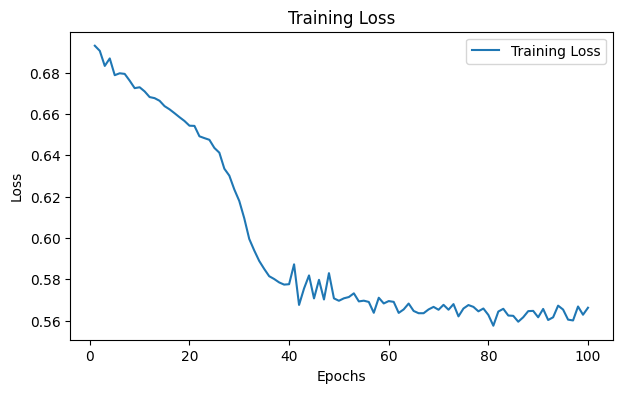

In [26]:
# 绘制训练损失和AUC曲线
epochs = range(1, 101)

plt.figure(figsize=(7, 4))
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

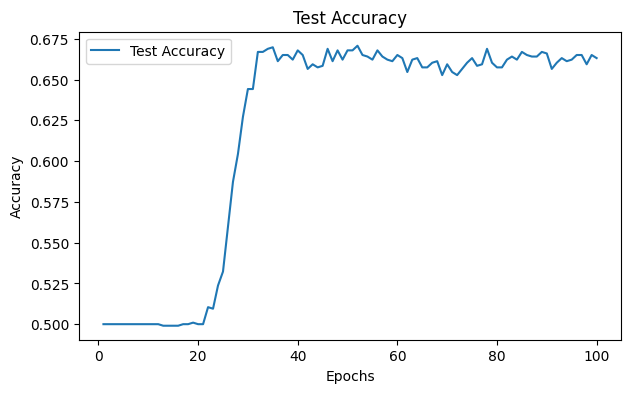

In [28]:
# 绘制测试准确率曲线
plt.figure(figsize=(7, 4))
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()

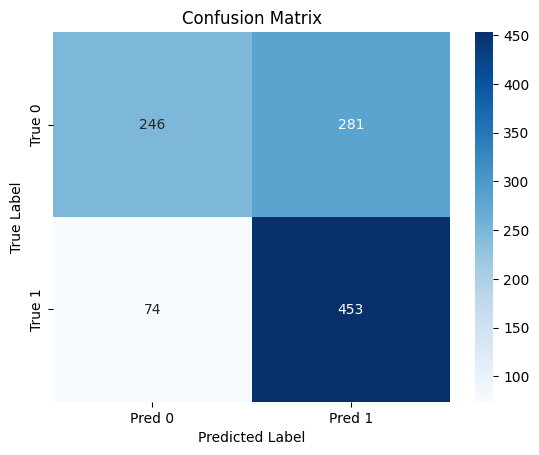

In [30]:
@torch.no_grad()
def get_predictions(data, model):
    model.eval()
    
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_edge_index = data['test_pos_edge_index']
    neg_edge_index = data['test_neg_edge_index']
    
    link_logits = model.decode(z, pos_edge_index, neg_edge_index)
    link_probs = link_logits.sigmoid()
    link_labels = get_link_labels(pos_edge_index, neg_edge_index)
    
    predictions = (link_probs > 0.5).int().cpu().numpy()
    true_labels = link_labels.cpu().numpy()
    
    return true_labels, predictions

true_labels, predictions = get_predictions(data, model)

# 绘制混淆矩阵
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()